In [7]:
using DifferentialEquations, Plots, FFTW


In [ ]:
# Parameters
Nx, Ny = 128, 128         # Grid points
Lx, Ly = 10.0, 10.0       # Domain size
dx, dy = Lx / Nx, Ly / Ny # Grid spacing
gamma = 1.0               # Parameter in the PDE
total_time = 2.0          # Total simulation time

# Spatial grid
x = range(-Lx/2, Lx/2, length=Nx)
y = range(-Ly/2, Ly/2, length=Ny)

# Laplacian using circshift
function laplacian(u, Nx, Ny, dx, dy)
    u = reshape(u, Nx, Ny)
    lap = circshift(u, (1, 0)) + circshift(u, (-1, 0)) +
          circshift(u, (0, 1)) + circshift(u, (0, -1)) - 4u
    return lap / dx^2
end

# Biharmonic operator
function biharmonic(u, Nx, Ny, dx, dy)
    lap = laplacian(u, Nx, Ny, dx, dy)
    return laplacian(vec(lap), Nx, Ny, dx, dy)
end

# Initial condition
w0 = [exp(-x[i]^2 - y[j]^2) for i in 1:Nx, j in 1:Ny] # Gaussian

# Define the PDE as an ODE problem
function pde!(dw, w, p, t)
    Nx, Ny, dx, dy, gamma = p
    w_mat = reshape(w, Nx, Ny)
    Lap = laplacian(w_mat, Nx, Ny, dx, dy)
    Bih = biharmonic(w_mat, Nx, Ny, dx, dy)
    dw_mat = -Bih - gamma * Lap
    dw[:] = vec(dw_mat) # Convert back to vector form
end

# Problem dimensions and parameters
p = (Nx, Ny, dx, dy, gamma)
w0_vec = vec(w0) # Flatten initial condition to a vector
tspan = (0.0, total_time)

# Set up the ODE problem
prob = ODEProblem(pde!, w0_vec, tspan, p)

# Solve the PDE
time_points = 0:0.1:total_time
sol = solve(prob, TRBDF2(), saveat=time_points) # Stiff solver

# Animation
anim = @animate for (i, t) in enumerate(time_points)
    w = reshape(sol.u[i], Nx, Ny) # Reshape solution back to 2D
    contourf(x, y, w, xlabel="x", ylabel="y", 
             title="w at t=$(round(t, digits=2))", 
             color=:viridis, clims=(-1.0, 1.0), aspect_ratio=:equal)
end

# Save Animation
gif(anim, "w_2d_animation.gif", fps=20)


[ Info: Saved animation to c:\Users\Hp\Useful stuff\acads stuff\8th sem\btp\villi\power_spectrum_animation.gif


Plots.AnimatedGif("c:\\Users\\Hp\\Useful stuff\\acads stuff\\8th sem\\btp\\villi\\power_spectrum_animation.gif")
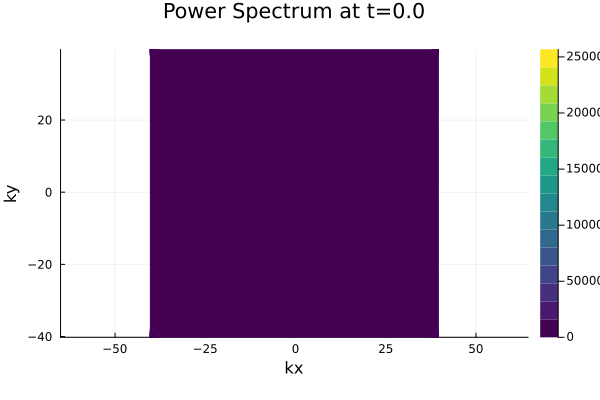

In [ ]:
# Function to compute the power spectrum
function compute_power_spectrum(w::Array{Float64, 2})
    # Compute the 2D Fourier Transform of w
    fft_w = fft(w)
    
    # Compute the power spectrum (magnitude squared of the Fourier coefficients)
    power_spectrum = abs.(fft_w).^2

    # Shift the zero-frequency component to the center
    power_spectrum_shifted = fftshift(power_spectrum)

    return power_spectrum_shifted
end

function define_frequencies(Nx::Int, Ny::Int, Lx::Float64, Ly::Float64)
    # Unsorted frequencies
    kx_unsorted = fftshift(-Nx/2:Nx/2-1) * (2π / Lx)
    ky_unsorted = fftshift(-Ny/2:Ny/2-1) * (2π / Ly)

    # Sort frequencies and get sorting indices
    kx_sorted = sort(kx_unsorted)
    ky_sorted = sort(ky_unsorted)
    kx_idx = sortperm(kx_unsorted)  # Sorting indices for kx
    ky_idx = sortperm(ky_unsorted)  # Sorting indices for ky

    return kx_sorted, ky_sorted, kx_idx, ky_idx
end

# Function to animate the power spectrum
function animate_power_spectrum(sol, time_points, Nx::Int, Ny::Int, Lx::Float64, Ly::Float64)
    # Define and sort spatial frequencies
    kx_sorted, ky_sorted, kx_idx, ky_idx = define_frequencies(Nx, Ny, Lx, Ly)

    # Animation of the power spectrum over time
    anim_spectrum = @animate for (i, t) in enumerate(time_points)
        # Get w for the current time step
        w = reshape(sol.u[i], Nx, Ny)
        
        # Compute the power spectrum
        power_spectrum = compute_power_spectrum(w)

        # Reorder rows and columns of the power spectrum to match sorted kx and ky
        power_spectrum_sorted = power_spectrum[kx_idx, ky_idx]

        # Plot the power spectrum
        contourf(kx_sorted, ky_sorted, power_spectrum_sorted, 
                 xlabel="kx", ylabel="ky", 
                 title="Power Spectrum at t=$(round(t, digits=2))", 
                 color=:viridis, aspect_ratio=:equal, clims=(0, maximum(power_spectrum_sorted)))
    end

    return anim_spectrum
end

# Example Usage
# Assuming `sol` is the solution obtained from solving your PDE
Nx, Ny = 128, 128
Lx, Ly = 10.0, 10.0
time_points = 0:0.1:2.0  # Example time points

# Call the animate function to generate the animation
anim_spectrum = animate_power_spectrum(sol, time_points, Nx, Ny, Lx, Ly)
gif(anim_spectrum, "power_spectrum_animation.gif", fps=20)
